In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import pandas as pd
from country_list import countries_for_language
from src.data.some_dataloader import *
from collections import defaultdict
import matplotlib.pyplot as plt

In [38]:
def country_occurences_in_files():
    countries = list(dict(countries_for_language('en')).values())

    counts = defaultdict(dict)

    for file_ in plaintext_files_iterator():
        filename = file_.split('/')[-1]
        with open(file_, 'r') as f:
            content = f.read()
            
            for country in countries:
                counts[country][filename] = content.count(country)
                
    df = pd.DataFrame(counts)
    return df

In [40]:
country_data = country_occurences_in_files()
country_data.head()

,Afghanistan,Åland Islands,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antarctica,Antigua & Barbuda,...,Uzbekistan,Vanuatu,Vatican City,Venezuela,Vietnam,Wallis & Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%C3%85land.txt,0,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%C3%89douard_Manet.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%C3%89ire.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%C3%93engus_I_of_the_Picts.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
def filter_top_k(df, k, N):
    filtered_df = pd.DataFrame(index=df.index, columns=[f"Top_{i+1}_name" for i in range(k)] + [f"Top_{i+1}_count" for i in range(k)])
    
    for row in df.iterrows():
        filename = row[0]
        data = row[1]
        top_counts = data.sort_values(ascending=False)
        
        top_countries = top_counts[top_counts > N].head(k)
        top_countries_name = top_countries.index.tolist()

        
        for i, country in enumerate(top_countries_name):
            filtered_df.loc[filename, f"Top_{i+1}_name"] = country
            
        for i, country in enumerate(top_countries):
            filtered_df.loc[filename, f"Top_{i+1}_count"] = country
        
    return filtered_df
                
counts = filter_top_k(country_data, k=3, N=1)
counts

,Top_1_name,Top_2_name,Top_3_name,Top_1_count,Top_2_count,Top_3_count
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt,Ireland,Isle of Man,NaN,8,4,NaN
%C3%85land.txt,Finland,Åland Islands,Sweden,36,16,12
%C3%89douard_Manet.txt,Italy,France,NaN,2,2,NaN
%C3%89ire.txt,Ireland,Canada,United Kingdom,43,4,2
%C3%93engus_I_of_the_Picts.txt,Ireland,NaN,NaN,9,NaN,NaN
...,...,...,...,...,...,...
Zirconium.txt,India,NaN,NaN,2,NaN,NaN
Zoroaster.txt,Iran,Tajikistan,NaN,15,3,NaN
Zuid-Gelders.txt,Netherlands,Germany,NaN,2,2,NaN
Zulu.txt,South Africa,Zimbabwe,Mozambique,15,3,2


In [47]:
df_cleaned = counts.dropna(how='all')
df_cleaned

,Top_1_name,Top_2_name,Top_3_name,Top_1_count,Top_2_count,Top_3_count
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt,Ireland,Isle of Man,NaN,8,4,NaN
%C3%85land.txt,Finland,Åland Islands,Sweden,36,16,12
%C3%89douard_Manet.txt,Italy,France,NaN,2,2,NaN
%C3%89ire.txt,Ireland,Canada,United Kingdom,43,4,2
%C3%93engus_I_of_the_Picts.txt,Ireland,NaN,NaN,9,NaN,NaN
...,...,...,...,...,...,...
Zion_National_Park.txt,United States,India,NaN,3,3,NaN
Zirconium.txt,India,NaN,NaN,2,NaN,NaN
Zoroaster.txt,Iran,Tajikistan,NaN,15,3,NaN
Zuid-Gelders.txt,Netherlands,Germany,NaN,2,2,NaN


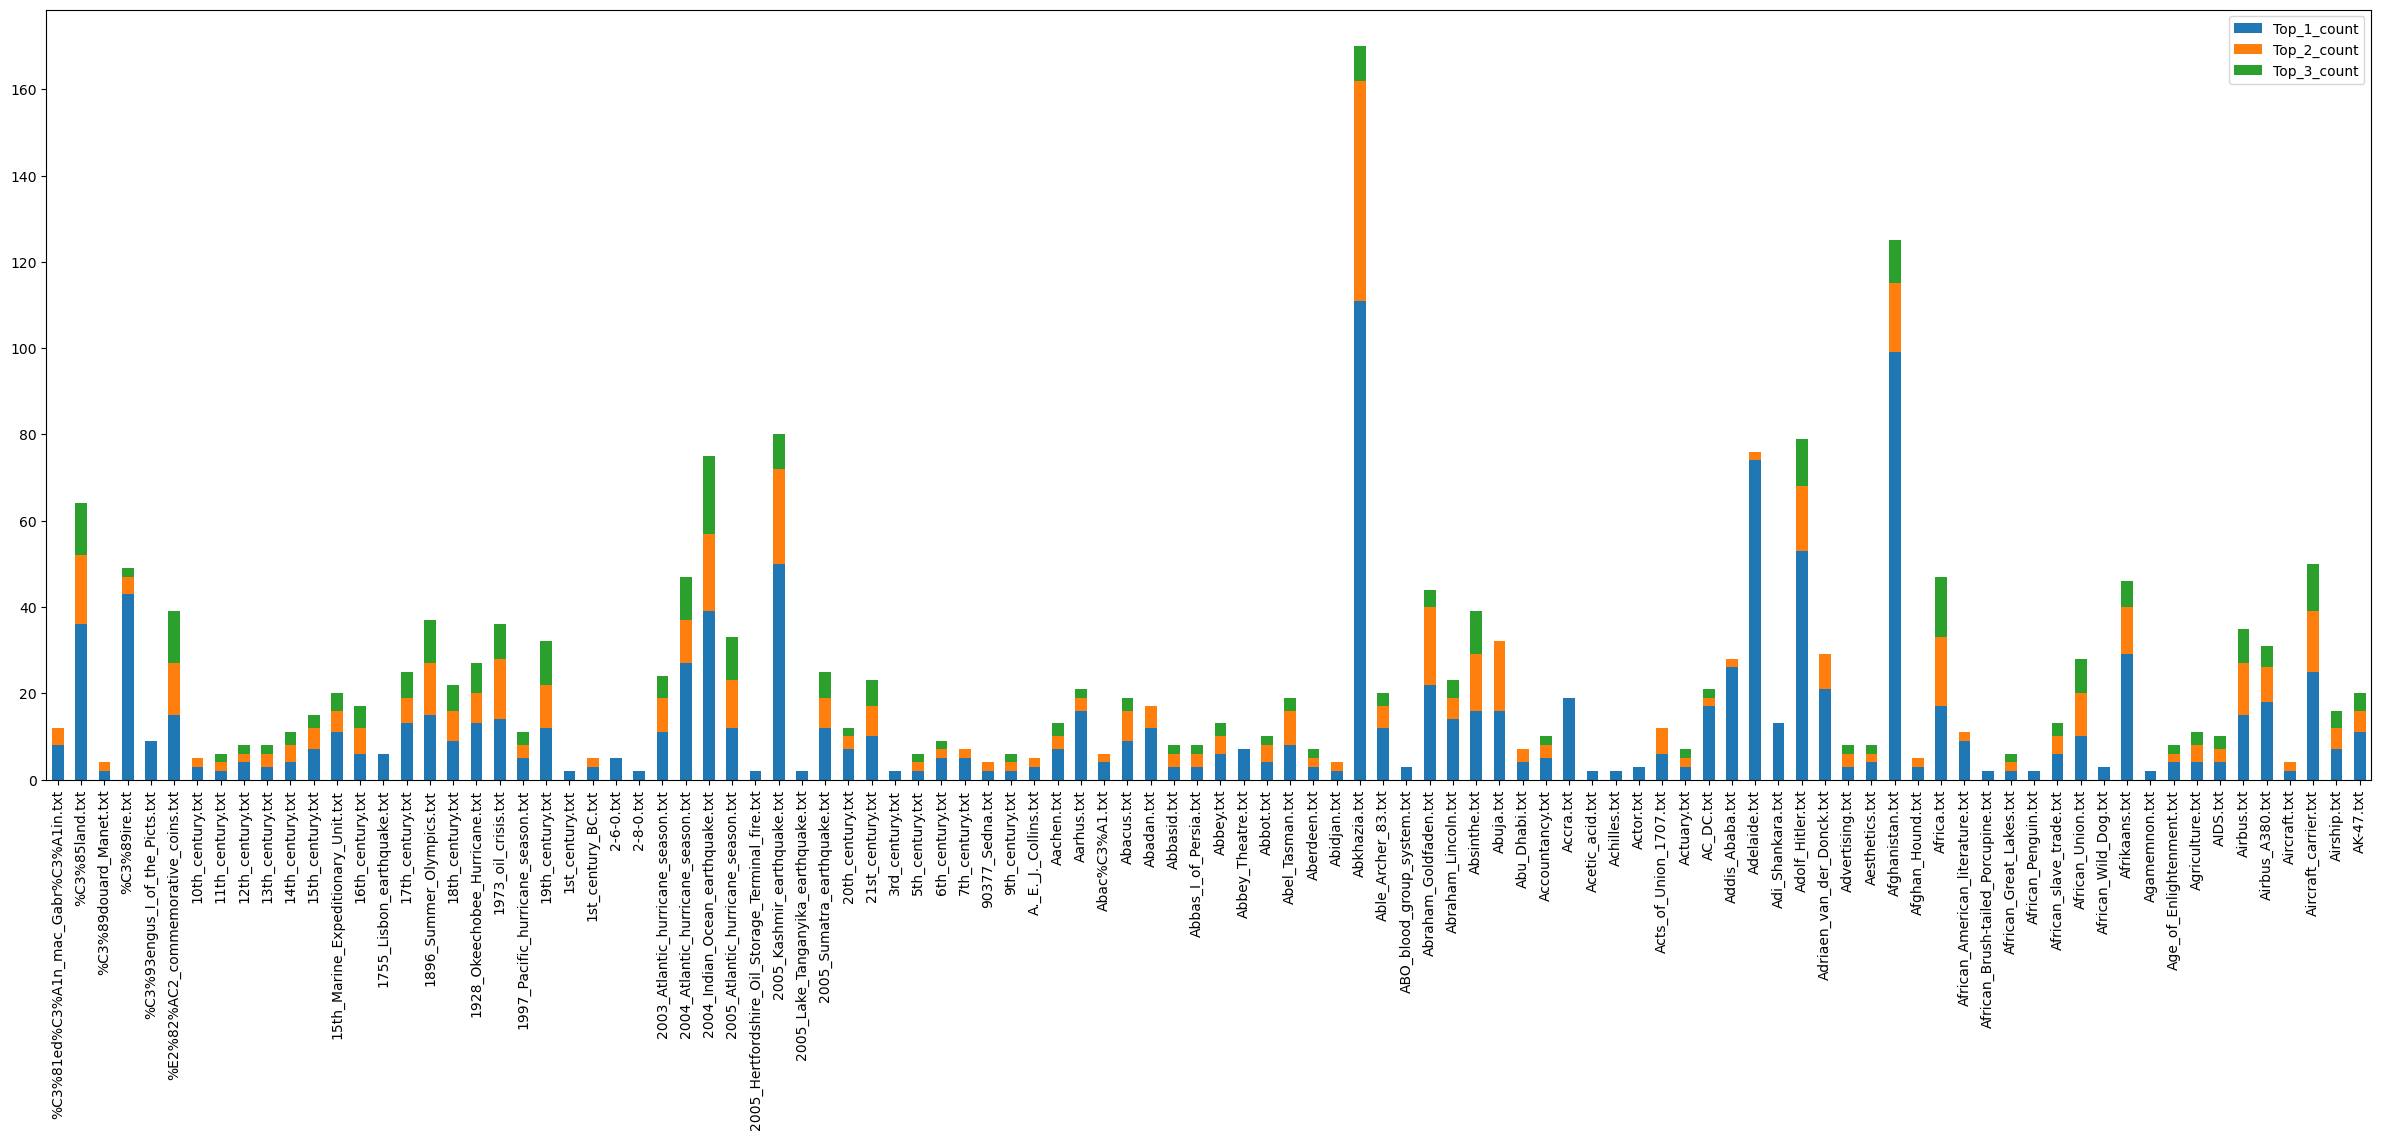

In [54]:
df_cleaned.head(100).plot(kind='bar', stacked=True, figsize=(30, 10))

plt.xticks(fontsize=10)

plt.show()

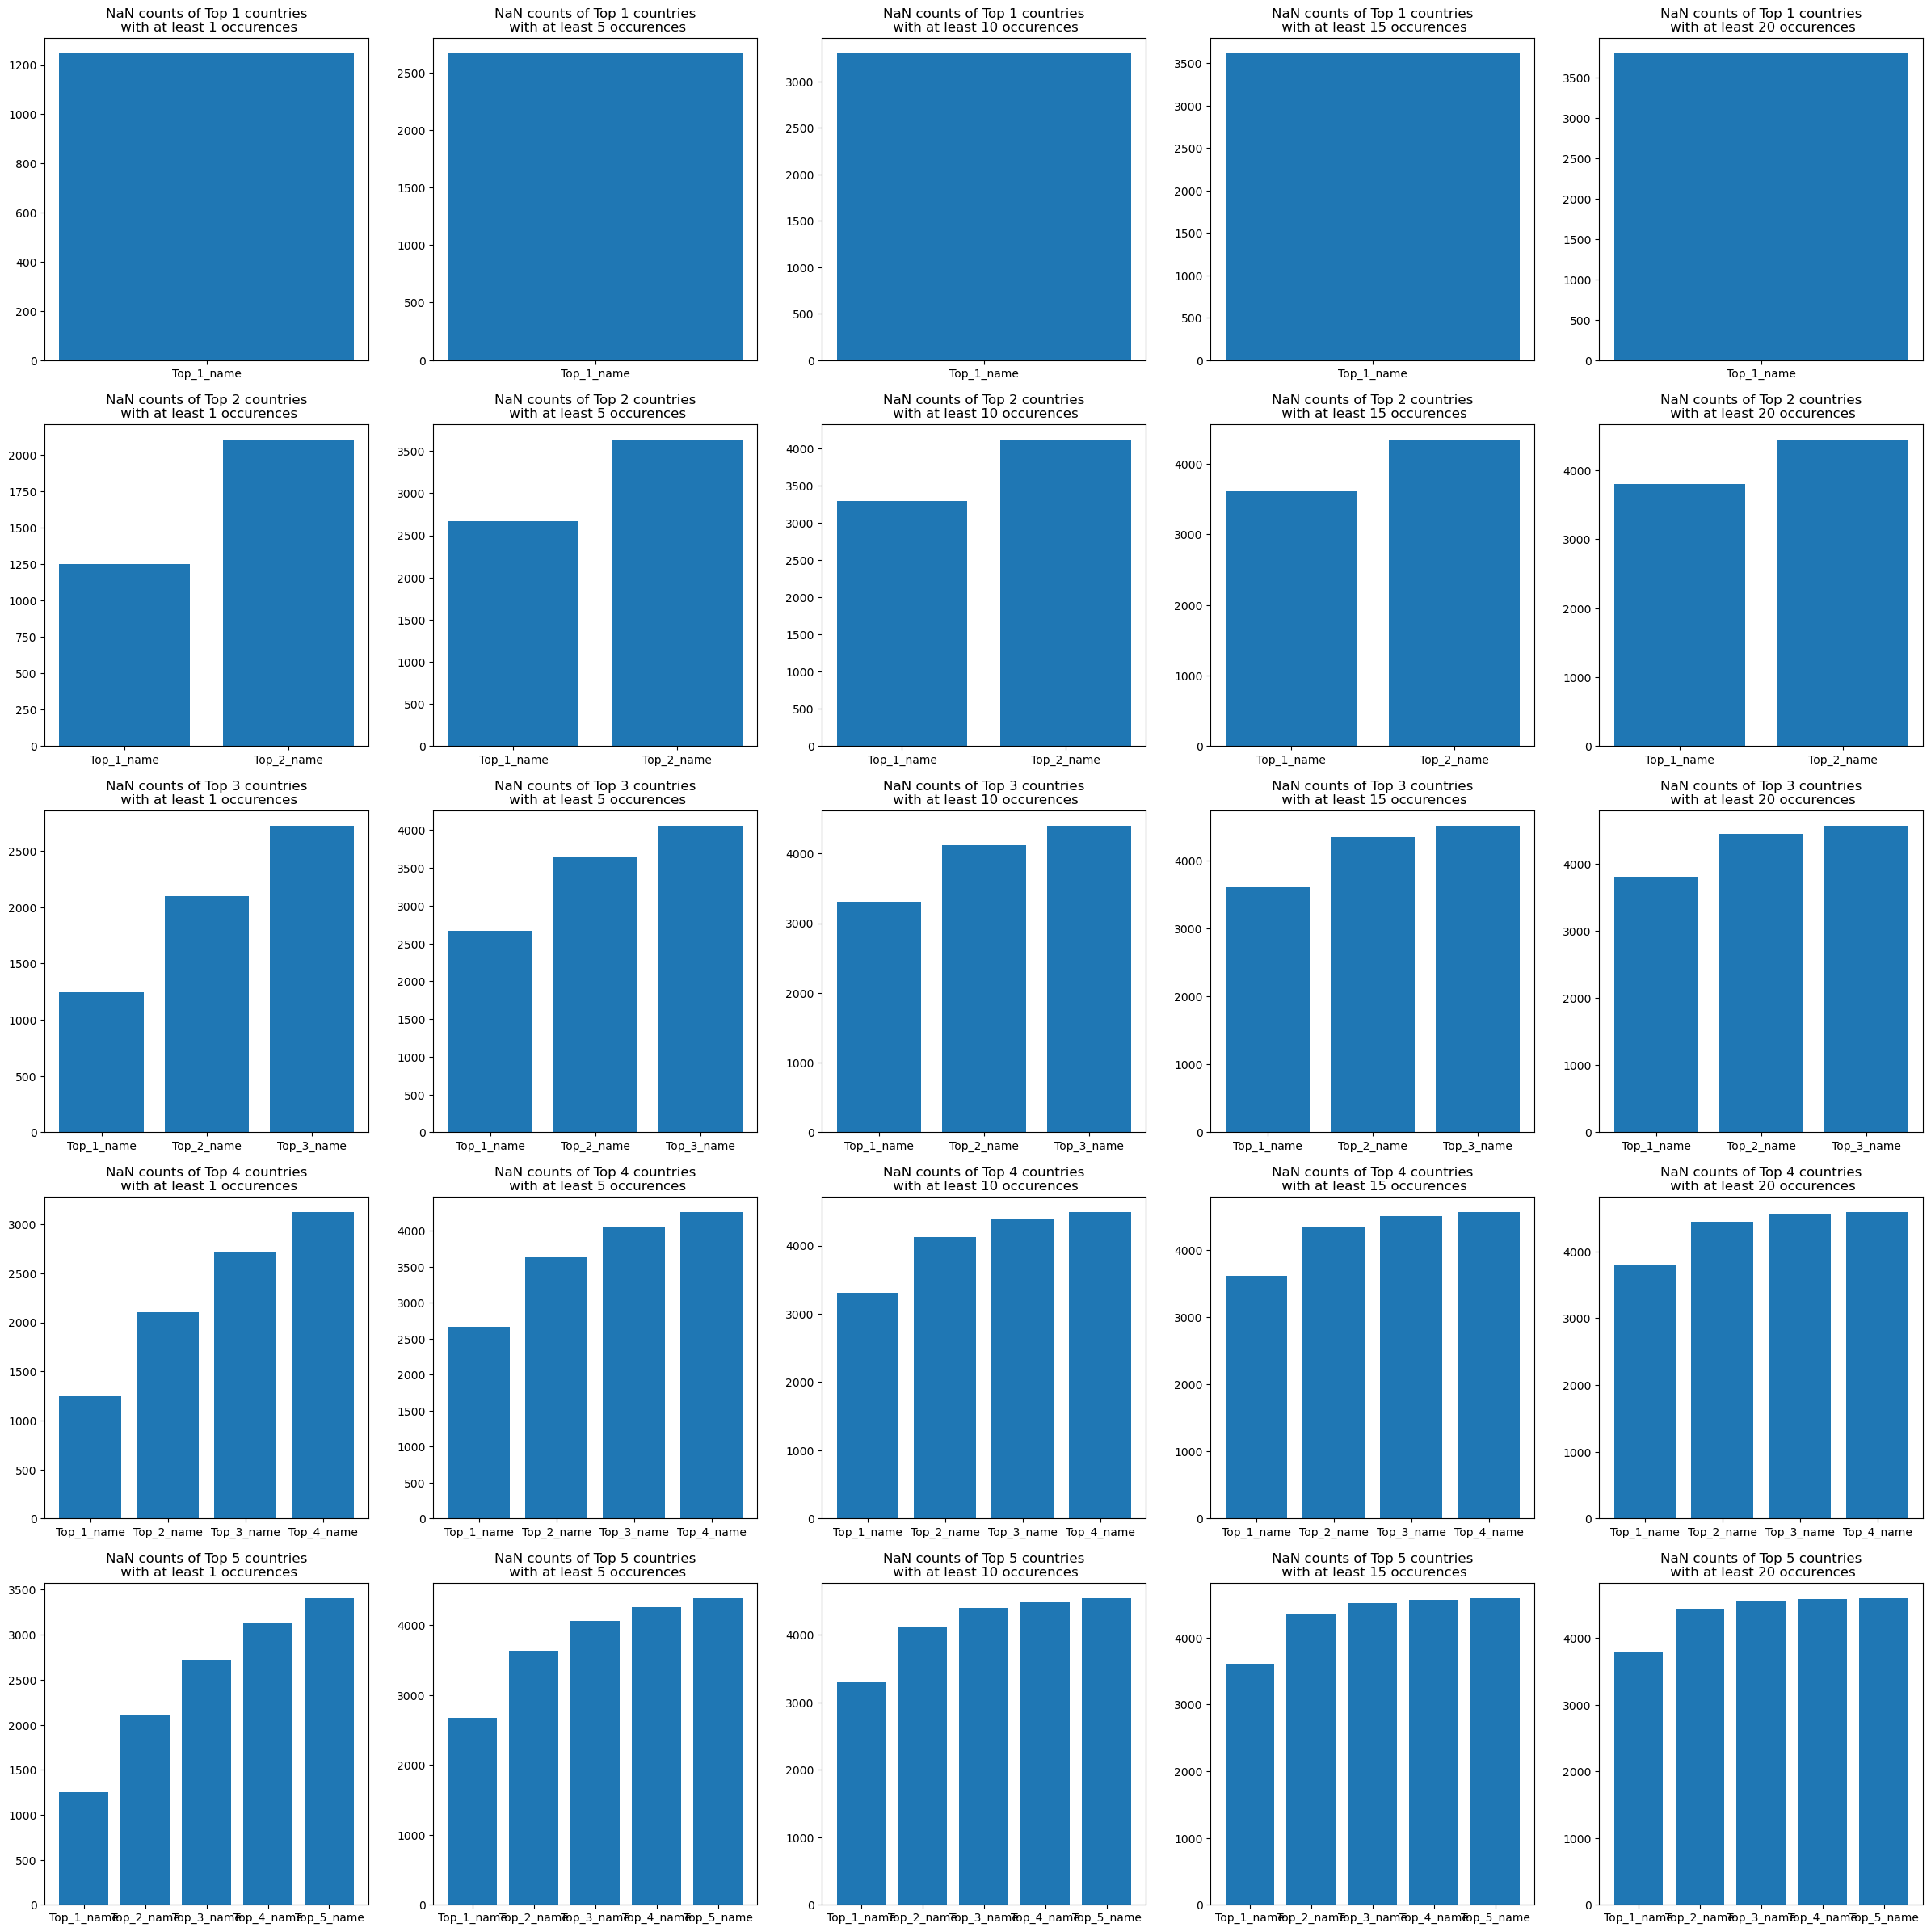

In [63]:
k_samples = [1, 2, 3, 4, 5]
N_samples = [1, 5, 10, 15, 20]

fig, axs = plt.subplots(len(k_samples), len(N_samples), figsize=(30, 30))

for i, k in enumerate(k_samples):
    for j, N in enumerate(N_samples):
        counts = filter_top_k(country_data, k=k, N=N)
        df_cleaned = counts.iloc[:, :k]
        df_stat = df_cleaned.isna().sum()
        axs[i, j].bar(df_stat.index, df_stat)
        axs[i, j].set_title(f"NaN counts of Top {k} countries\n with at least {N} occurences")
